## 기본설정 및 전처리

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.graph_objs as go
import plotly.offline as offline
from plotly.subplots import make_subplots
import folium
from folium import plugins
from folium.plugins import HeatMap
from folium import FeatureGroup
import json
import math
import re
from datetime import datetime
import os
import glob
import subprocess
from bs4 import BeautifulSoup as bs
from shapely.geometry import Point, Polygon, LineString
import geopandas as gpd
from geopandas import GeoSeries
import pyproj
from tqdm import tqdm
#from keplergl import KeplerGl

# 모든 열이 생략되지 않도록 설정
pd.set_option('display.max_columns', None)

In [2]:
# Polygon을 만드는 함수
def make_pol(x):
    try:
        return Polygon(x[0])
    except:
        return Polygon(x[0][0])

In [3]:
# Linestring을 만드는 함수
def make_lin(x):
    try:
        return LineString(x)
    except:
        return LineString(x[0])

In [4]:
# 데이터프레임을 GeoPandas 데이터프레임으로 변환하는 함수 정의
def geo_transform(DataFrame) :
    # csv to geopandas
    # lon, lat data를 geometry로 변경
    DataFrame['lat'] = DataFrame['lat'].astype(float)
    DataFrame['lon'] = DataFrame['lon'].astype(float)
    DataFrame['geometry'] = DataFrame.apply(lambda row : Point([row['lon'], row['lat']]), axis=1) # 위도 및 경도롤 GeoPandas Point 객체로 변환
    DataFrame = gpd.GeoDataFrame(DataFrame, geometry='geometry')
    DataFrame.crs = {'init':'epsg:4326'} # geopandas 데이터프레임의 좌표계를 EPSG 4326으로 설정
    DataFrame = DataFrame.to_crs({'init':'epsg:4326'}) # 데이터프레임의 좌표계를 자체 좌표계에서 EPSG 4326으로 변환
    return DataFrame

### 청주시_도시재생계획구역

In [27]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/27.청주시_도시재생계획구역.geojson', encoding='utf-8') as geojson_file:
    geojson_data = json.load(geojson_file)
crp_df = pd.json_normalize(geojson_data) # city_revitalize_planning_map_df
crp_df['geometry'] = crp_df['geometry.coordinates'].apply(lambda x : make_pol(x))
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)

# 폴리곤의 중점을 찾음
centroid = crp_df['geometry'].iloc[0].centroid.buffer(0.01) # 1도의 위도 변화는 대략 111.32 킬로미터
crp_df['centroid_polygon_geometry'] = [centroid]
crp_df

,type,properties.fid,properties.구역명,geometry.type,geometry.coordinates,geometry,centroid_polygon_geometry
0,Feature,5,도시재생구역도,Polygon,"[[[127.4833417, 36.6318644], [127.4833417, 36....","POLYGON ((127.4833417 36.6318644, 127.4833417 ...",POLYGON ((127.49847965416363 36.63603755594320...


### 격자(매핑용)

In [6]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/26.청주시_격자(매핑용).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
grid_map_df = pd.json_normalize(geojson_data['features'])
grid_map_df['geometry'] = grid_map_df['geometry.coordinates'].apply(lambda x : make_pol(x))

In [7]:
# crp_df에서 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
polygon_expanded = crp_df['centroid_polygon_geometry'].iloc[0]

# grid_map_df 데이터프레임을 GeoDataFrame으로 변환
grid_map_df = gpd.GeoDataFrame(grid_map_df, geometry='geometry')
#grid_map_df['geometry'] = GeoSeries(grid_map_df['geometry'])

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid = grid_map_df[grid_map_df['geometry'].intersects(polygon)].reset_index(drop=True) # polygon과 교차하거나 포함하는 경우를 모두 선택, within 은 포함
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_grid_expanded = grid_map_df[grid_map_df['geometry'].intersects(polygon_expanded)].reset_index(drop=True) # polygon_expanded과 교차하거나 포함하는 경우를 모두 선택

#### 청주시 상세 도로망 & 도로명주소 데이터 필터링 및 통합

In [55]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/13.청주시_상세도로망.geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadsystem_df = pd.json_normalize(geojson_data['features'])
roadsystem_df['geometry'] = roadsystem_df['geometry.coordinates'].apply(lambda x : LineString(x))
roadsystem_df['properties.link_id'] = roadsystem_df['properties.link_id'].astype(str)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadsystem_df = gpd.GeoDataFrame(roadsystem_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadsystem = roadsystem_df[roadsystem_df['geometry'].intersects(polygon)].reset_index(drop=True)

# GeoJSON 파일 불러오기
with open('SBJ_2309_001/16.청주시_도로명주소(도로).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
roadname_road_df = pd.json_normalize(geojson_data['features'])
roadname_road_df['geometry'] = roadname_road_df['geometry.coordinates'].apply(lambda x: LineString(x))
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
roadname_road_df = gpd.GeoDataFrame(roadname_road_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_roadname_road = roadname_road_df[roadname_road_df['geometry'].within(polygon)].reset_index(drop=True)

# 통합 도로망 df
tot_roadsystem = pd.concat([filtered_roadsystem[['geometry']], filtered_roadname_road[['geometry']]])

#### 청주시 시장현황 필터링

In [9]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
market_df = pd.read_csv('SBJ_2309_001/6.청주시_시장현황.csv')
market_df = geo_transform(market_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# market_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_market = market_df[market_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 주차장 현황

In [56]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
parking_df = pd.read_csv('SBJ_2309_001/7.청주시_주차장현황.csv')
parking_df = geo_transform(parking_df)
# 원도심 영역 buffer(도심반경 1.1km) 폴리곤
polygon = crp_df['geometry'].iloc[0]
# parking_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_parking = parking_df[parking_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 공공기관 및 주요지점 현황

In [11]:
public_df = pd.read_csv('SBJ_2309_001/25.청주시_공공기관_및_주요지점현황.csv')
# 데이터프레임을 GeoPandas 데이터프레임으로 변환
public_df = geo_transform(public_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# public_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_public = public_df[public_df['geometry'].within(polygon)]
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('공공기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('시군청', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('도단위기관', '행정기관')
filtered_points_public['inst_gbn'] = filtered_points_public['inst_gbn'].replace('민간기관', '상업시설')
filtered_points_public = filtered_points_public.drop_duplicates(subset='geometry', keep='first').reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

#### 청주시 공원 현황

In [12]:
# 시장 데이터프레임을 GeoPandas 데이터프레임으로 변환
park_df = pd.read_csv('SBJ_2309_001/8.청주시_공원현황.csv')
park_df = geo_transform(park_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# park_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_park = park_df[park_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 인도(보도) 시각화

In [58]:
# GeoJSON 파일 불러오기
with open('SBJ_2309_001/17.청주시_인도(보도).geojson', encoding="UTF8") as geojson_file:
    geojson_data = json.load(geojson_file)
sidewalk_df = pd.json_normalize(geojson_data['features'])
sidewalk_df['geometry'] = sidewalk_df['geometry.coordinates'].apply(make_lin)
# roadsystem_df 데이터프레임을 GeoDataFrame으로 변환
sidewalk_df = gpd.GeoDataFrame(sidewalk_df, geometry='geometry')
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_sidewalk = sidewalk_df[sidewalk_df['geometry'].intersects(polygon)].reset_index(drop=True)

#### 청주시 폐공장현황

In [14]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
factory_df = pd.read_csv('SBJ_2309_001/9.청주시_폐공장현황.csv')
factory_df = geo_transform(factory_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_factory = factory_df[factory_df['geometry'].within(polygon)]

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 문화재 현황

In [15]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
culture_assets_df = pd.read_csv('SBJ_2309_001/5.청주시_유적지_문화재현황.csv')
culture_assets_df = geo_transform(culture_assets_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]

# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_culture = culture_assets_df[culture_assets_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 학교 현황

In [16]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임 변환
school_df = pd.read_csv('SBJ_2309_001/24.청주시_학교현황.csv')
school_df = geo_transform(school_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_school = school_df[school_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 어린이집 유치원 현황

In [17]:
# 데이터프레임 로드 및 GeoPandas 데이터프레임으로 변환
kinder_df = pd.read_csv('SBJ_2309_001/28.청주시_어린이집_유치원현황.csv')
kinder_df = geo_transform(kinder_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry
# 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_kinder = kinder_df[kinder_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 상권정보 

In [18]:
# 상권정보 데이터 로드 및 GeoDataFrame으로 변환
trading_area_df = pd.read_csv('SBJ_2309_001/18.청주시_상권정보.csv')
trading_area_df = geo_transform(trading_area_df)
# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0]
# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_trading_area = trading_area_df[trading_area_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



#### 청주시 가로수 현황 (공공데이터포털 - 산림청_도시숲가로수관리 가로수 현황 https://www.data.go.kr/data/15120900/fileData.do)

In [19]:
'''산림청_도시숲가로수관리 가로수 현황_20221231 데이터 정제 완료 -'''
# street_tree_df = pd.read_csv('SBJ_2309_001/산림청_도시숲가로수관리 가로수 현황_20221231.csv', encoding='cp949')
# street_tree_df = street_tree_df[['시군구명', '도로구간명', '수종명', '지역X좌표', '지역Y좌표']]
# street_tree_df = street_tree_df[street_tree_df['시군구명'].str.contains('청주')].reset_index(drop=True)

# # EPSG 5186에서 EPSG 4326으로 좌표 변환을 수행하는 함수 생성
# def transform_coordinates(row):
#     in_proj = pyproj.Proj(init='epsg:5186')
#     out_proj = pyproj.Proj(init='epsg:4326')
#     lon, lat = pyproj.transform(in_proj, out_proj, row['지역X좌표'], row['지역Y좌표'])
#     return pd.Series({'lat': lat, 'lon': lon})

# # '지역X좌표'와 '지역Y좌표'를 EPSG 4326으로 변환하고 'lat' 및 'lon' 열로 이름 변경
# street_tree_df[['lat', 'lon']] = street_tree_df.apply(transform_coordinates, axis=1)
# # '지역X좌표'와 '지역Y좌표' 열을 삭제 (선택 사항)
# street_tree_df.drop(['지역X좌표', '지역Y좌표'], axis=1, inplace=True)

# 가로수 데이터프레임 로드 및 GeoPandas 변환
street_tree_df = pd.read_csv('SBJ_2309_001/29.청주시_가로수현황.csv', encoding='UTF8')
street_tree_df = geo_transform(street_tree_df)

# crp_df에서 첫 번째 폴리곤 영역을 선택 = crp_df는 원도심 영역(도시재생 대상지역)
polygon = crp_df['geometry'].iloc[0] # 또는 centroid_polygon_geometry

# factory_df의 'geometry' 열을 사용하여 Point 객체를 필터링
filtered_points_tree = street_tree_df[street_tree_df['geometry'].within(polygon)].reset_index(drop=True)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



## 원도심 불법주정차

In [20]:
illegal_parking_df = pd.read_csv('SBJ_2309_001/14.청주시_불법주정차단속통계.csv')
illegal_parking_df = geo_transform(illegal_parking_df)

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6

c:\Users\user\anaconda3\envs\GIS\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6




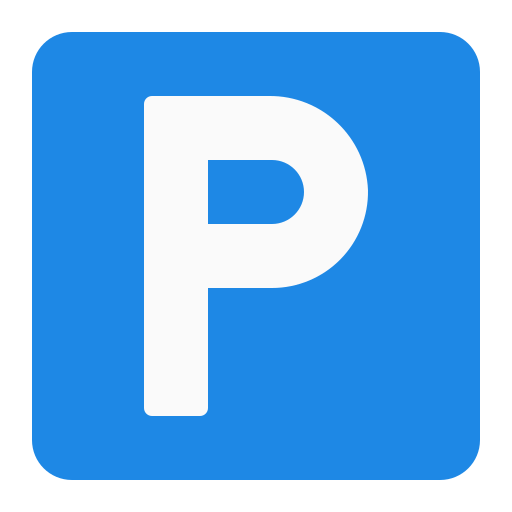
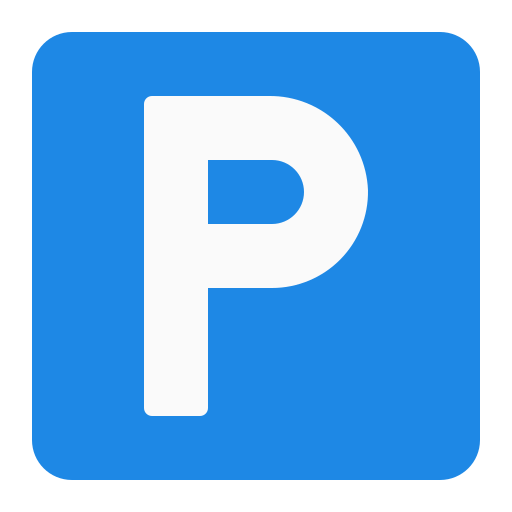
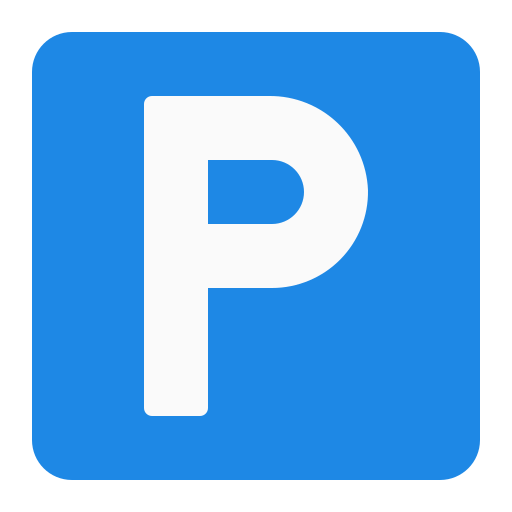
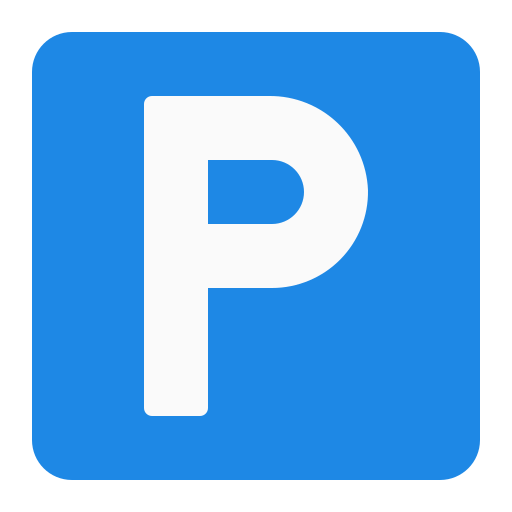
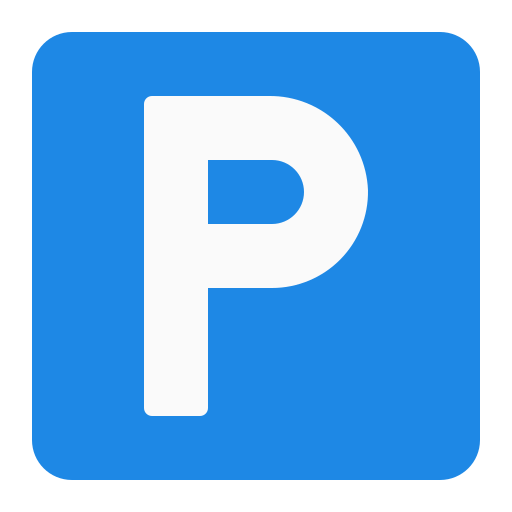
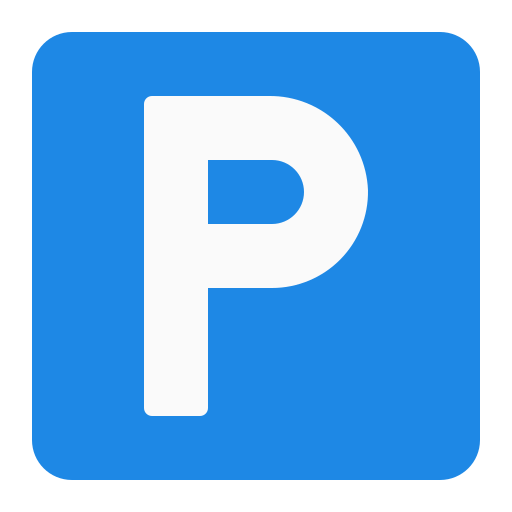
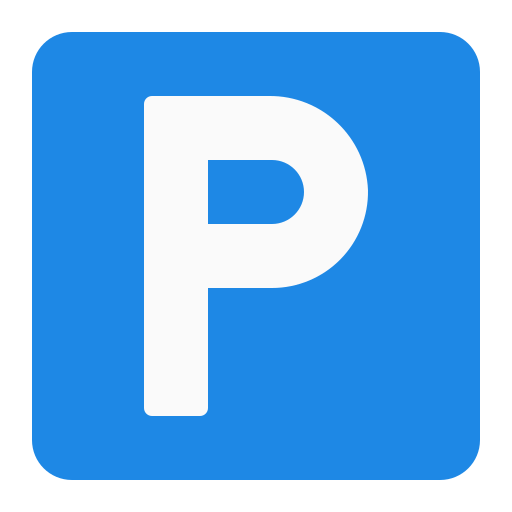
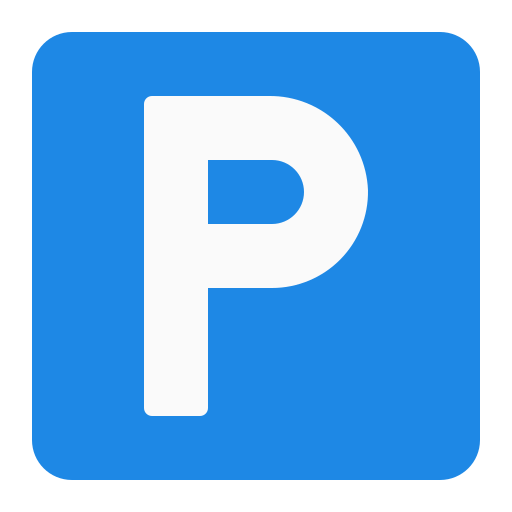
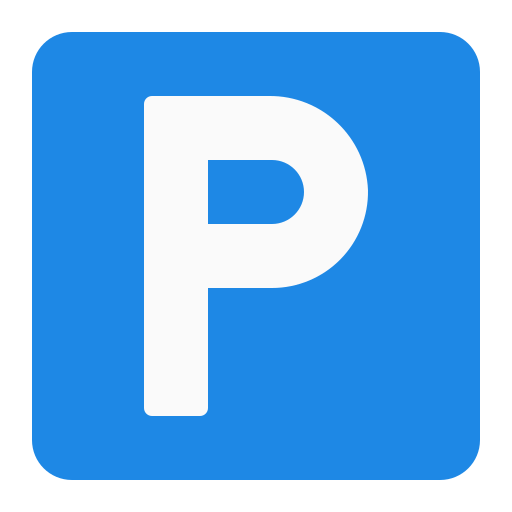
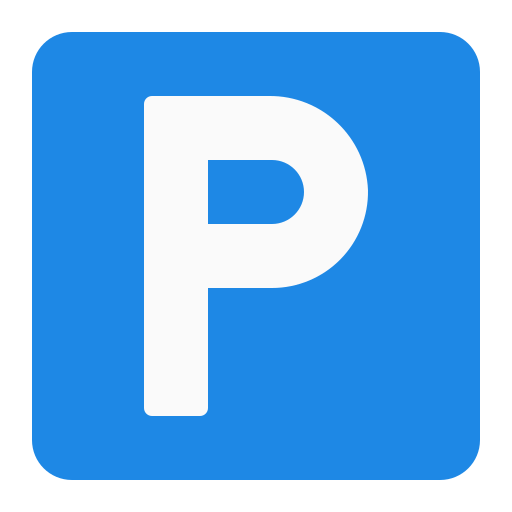
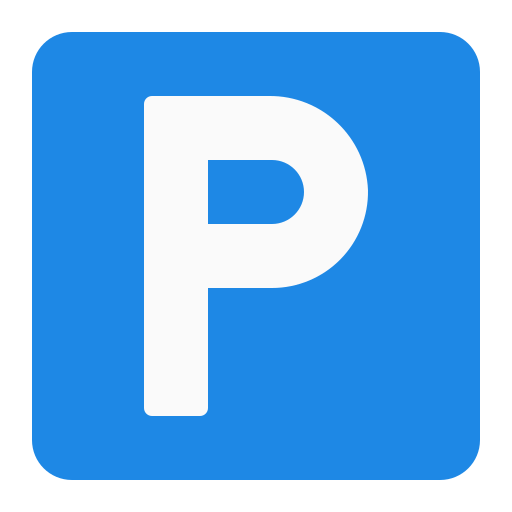
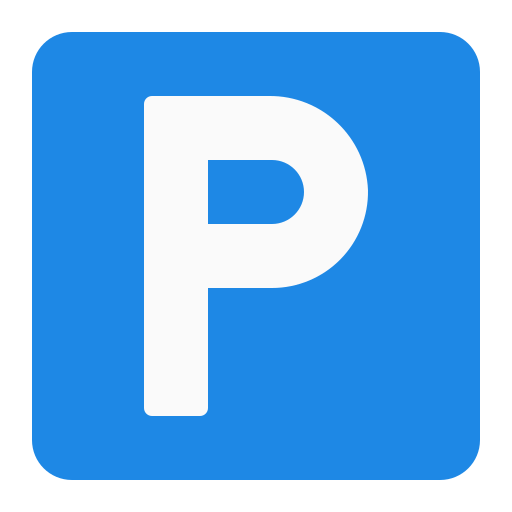
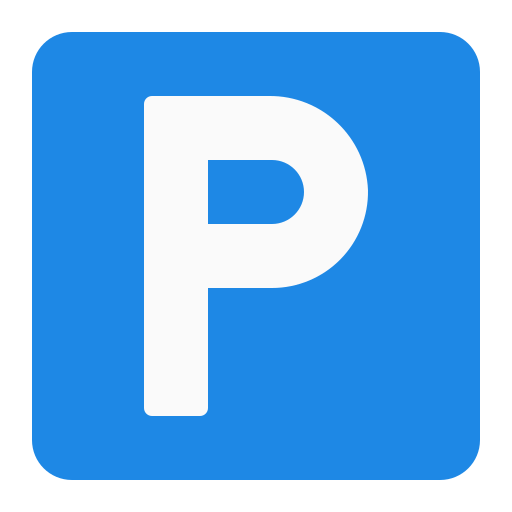
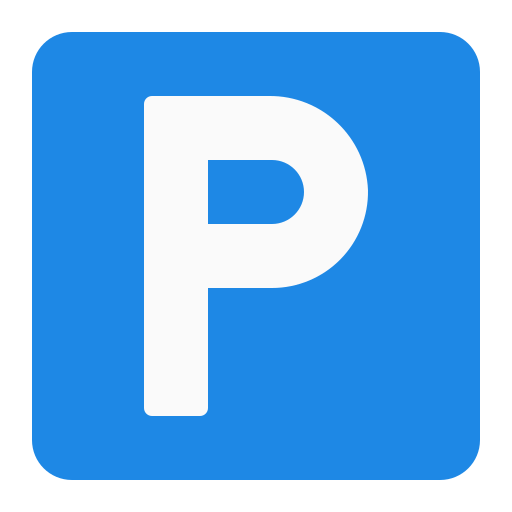
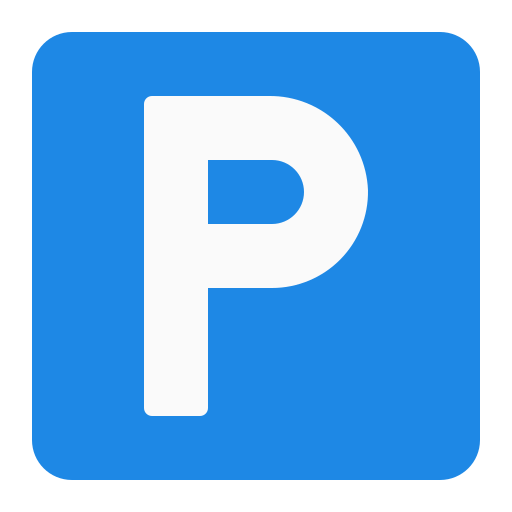
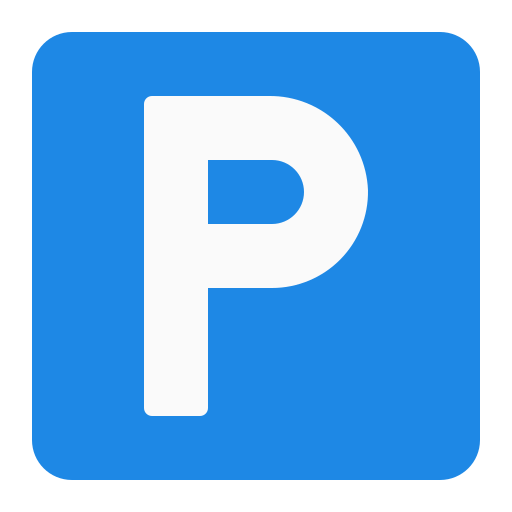
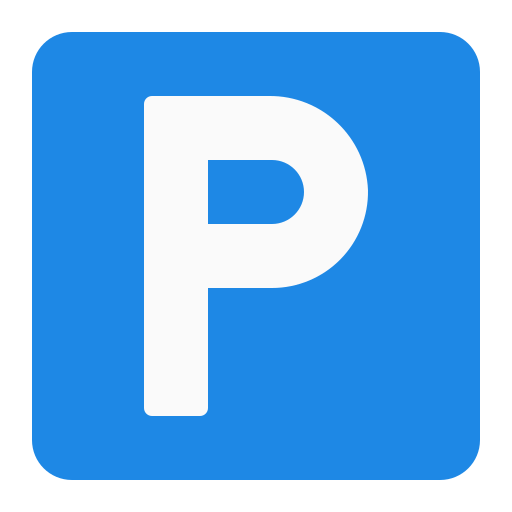
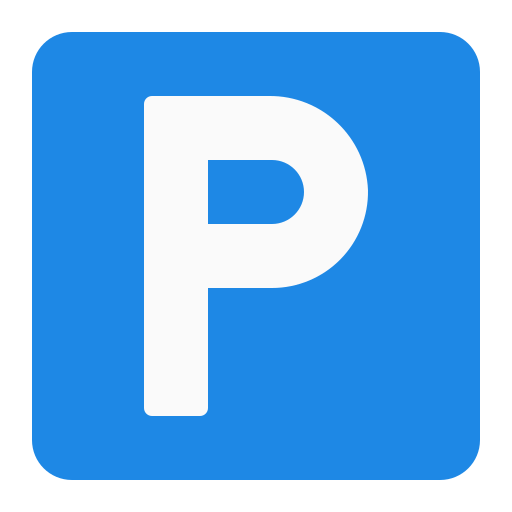
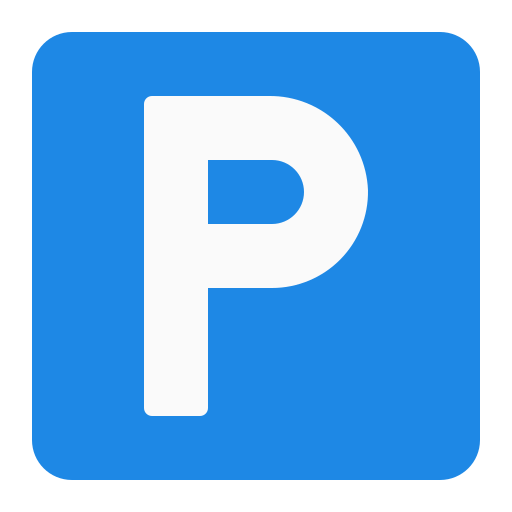
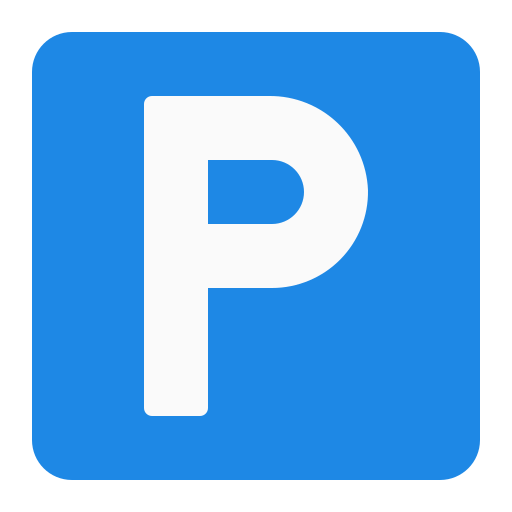
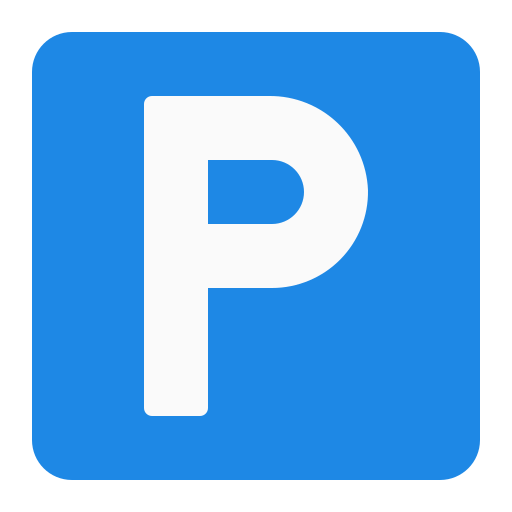
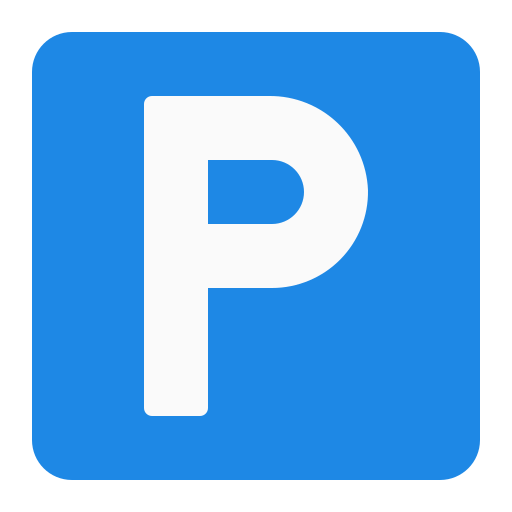
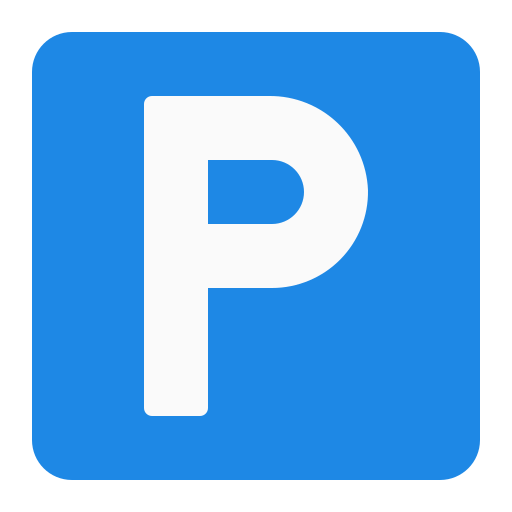
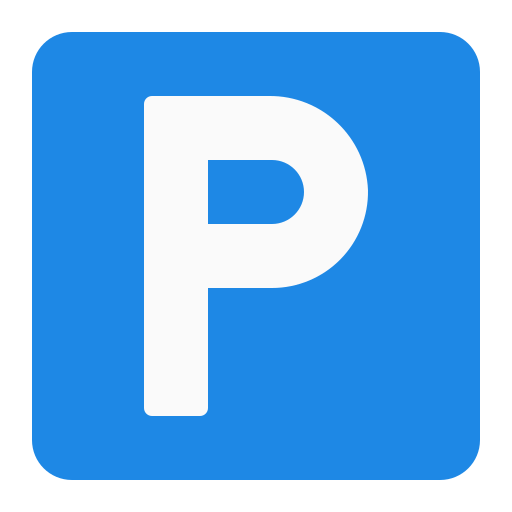
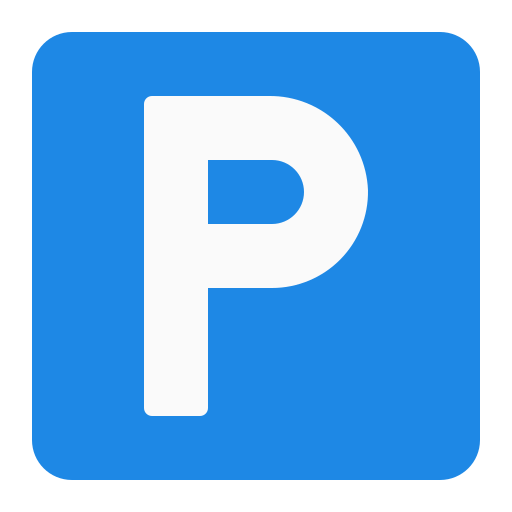
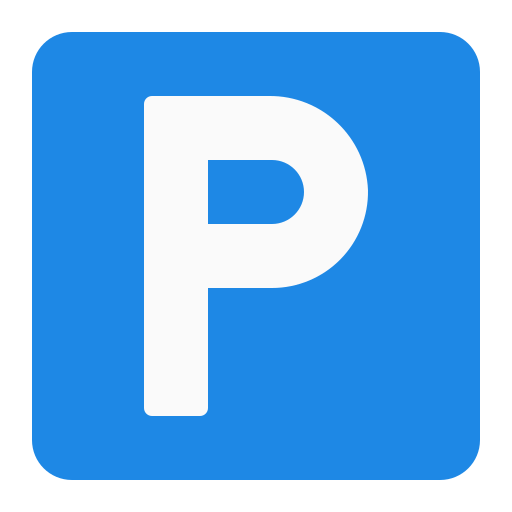
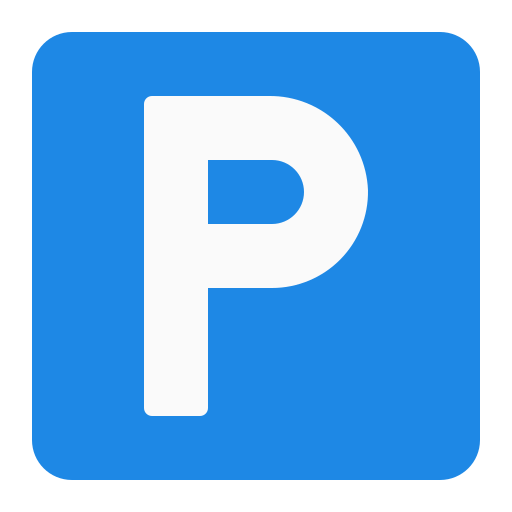
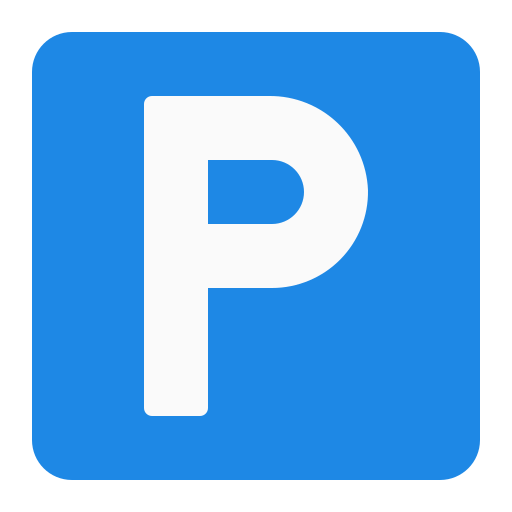
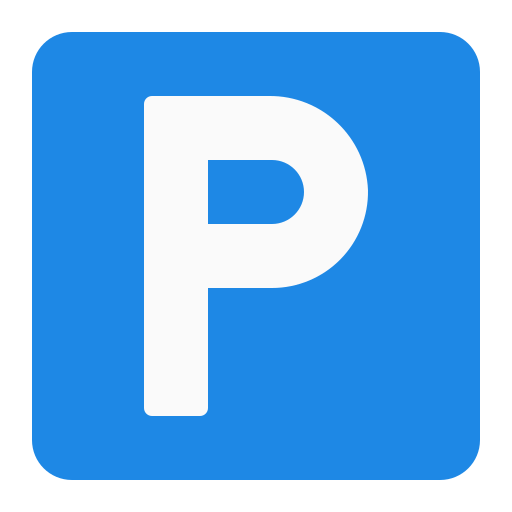
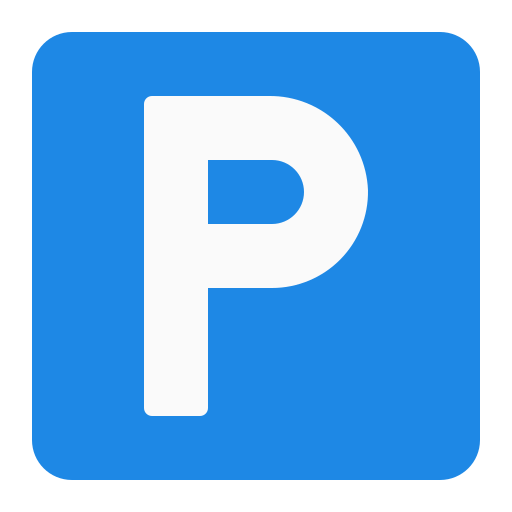
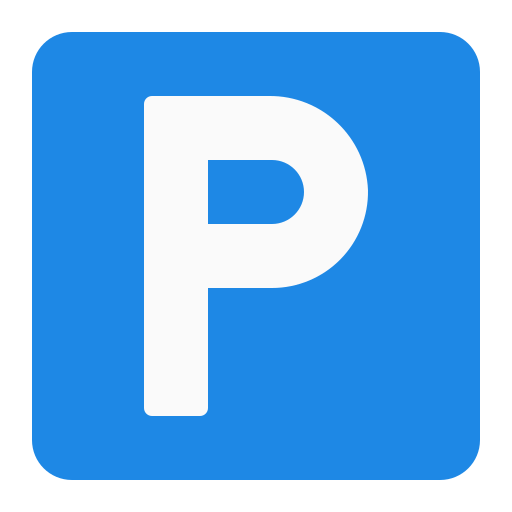
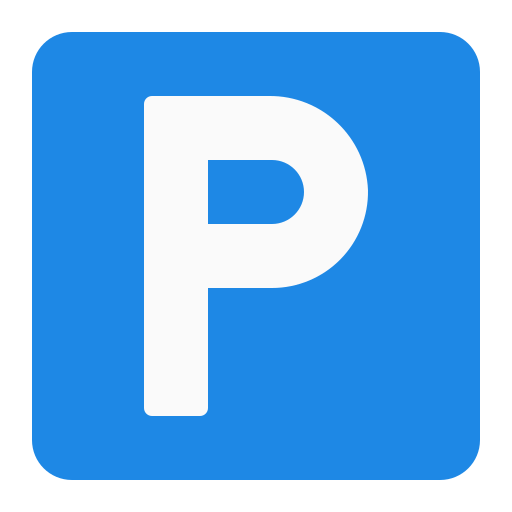
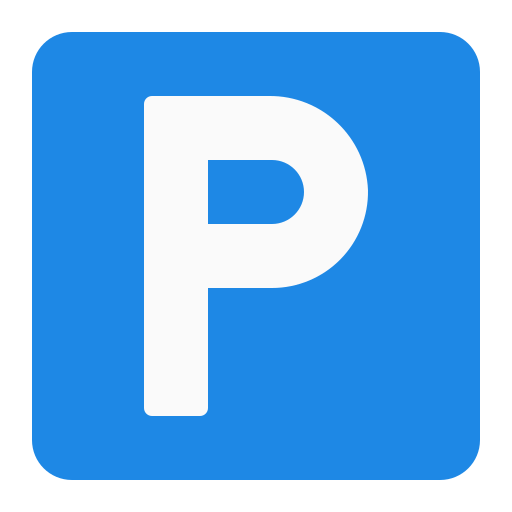
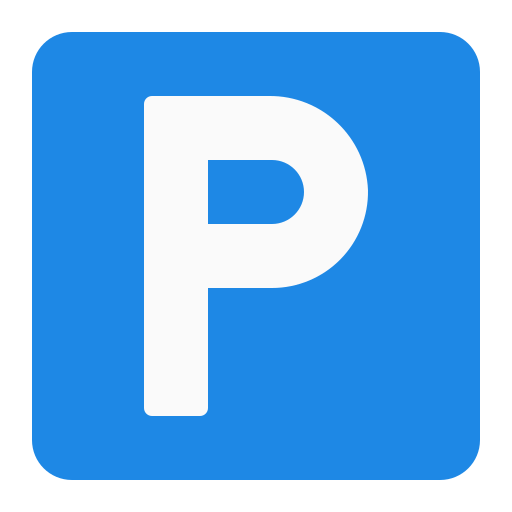
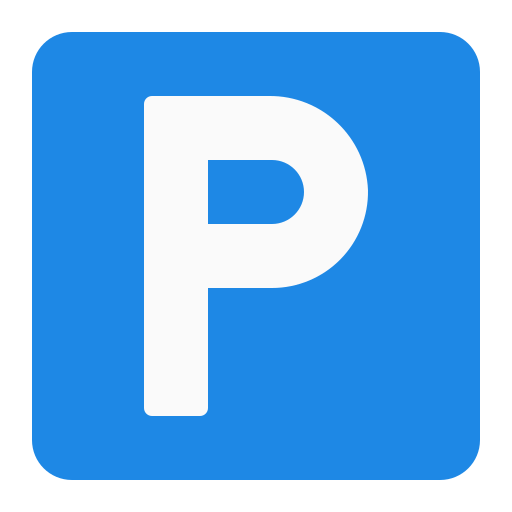
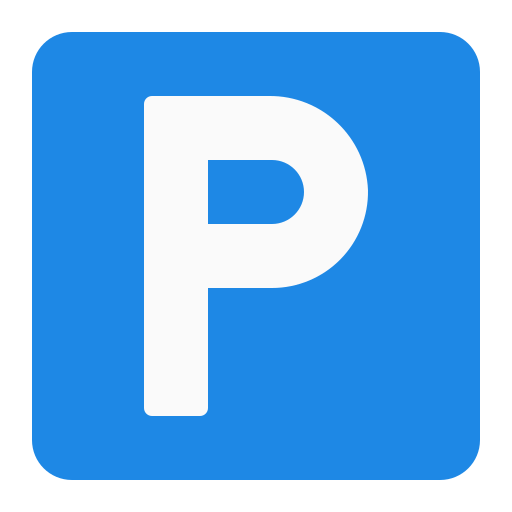
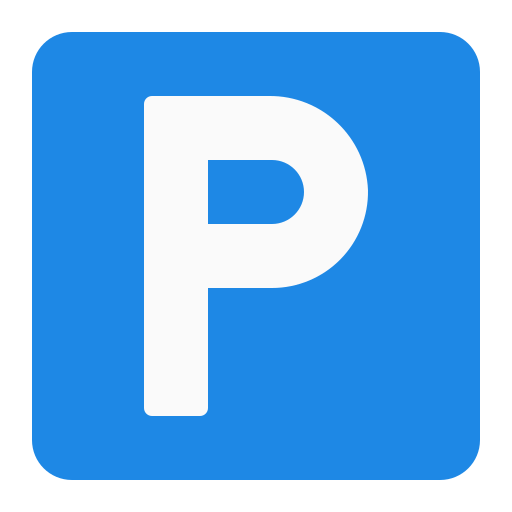
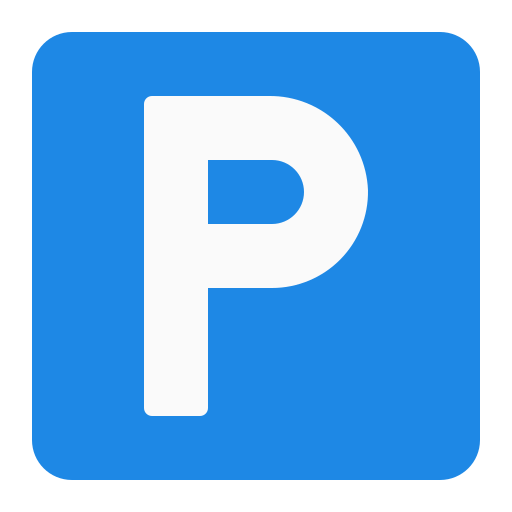
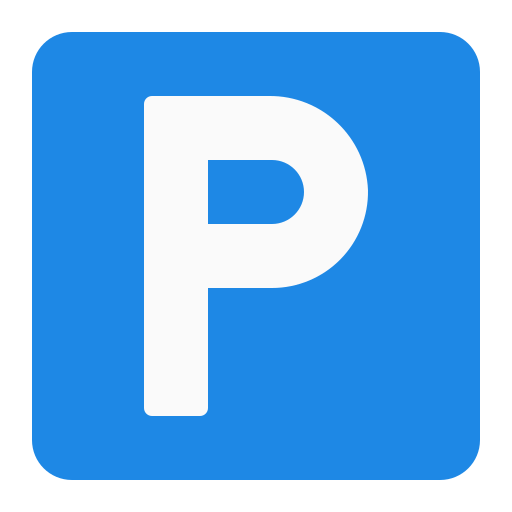
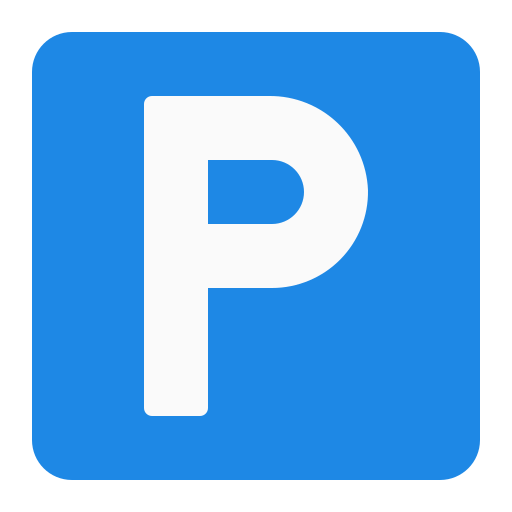

In [52]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943],  zoom_start=14)

# 기본 배경지도를 항상 표시하도록 설정 및 기본 도로망 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
grid_geojson = tot_roadsystem['geometry'].to_json()
grid_layer = folium.GeoJson(
    grid_geojson,
    name="도로망",
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'gray',
        'weight': 5
    })
grid_layer.add_to(m)

# crp_df의 각 다각형을 지도에 추가
for index, row in crp_df.iterrows():
    style_function = lambda x: {'fillColor': 'None', 'color': 'navy', 'weight': 2}
    polygon = folium.GeoJson(row['centroid_polygon_geometry'], name="도심반경 1.1km", style_function=style_function)  
    polygon.add_to(m)
    
# 인도 추가
m_sidewalk = folium.FeatureGroup(name="인도", overlay=True)
for _, row in filtered_sidewalk.iterrows() :
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature: {
            'fillColor': 'blue',
            'color': 'blue',
            'weight': 1
        }).add_to(m_sidewalk)
m_sidewalk.add_to(m)

# 불법주정차수를 정규화한 df제작
max_val = illegal_parking_df['cd_cnt'].max()
illegal_parking_df_re = illegal_parking_df.copy()
illegal_parking_df_re['cd_cnt'] = illegal_parking_df_re['cd_cnt'].apply(lambda x : (x/max_val) * 100)

# 'geometry' 열의 값을 위치 정보로 사용하여 불법주정차 HeatMap 생성
m_illegal_parking = folium.FeatureGroup(name="불법주정차", overlay=False)
heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0], cd_cnt] for point, cd_cnt in zip(illegal_parking_df_re['geometry'], illegal_parking_df_re['cd_cnt'])]
HeatMap(heat_data, max_opacity=0.6, radius=30).add_to(m_illegal_parking)
m_illegal_parking.add_to(m)

# 주차장 위치 매핑
m_parking = folium.FeatureGroup(name="주차장", overlay=True)
for _, row in filtered_points_parking.iterrows() :
    popup_text = f"{row['carpark_nm']} - {row['slots']}대"
    folium.Marker(location=(row['lat'], row['lon']),
    icon = folium.CustomIcon(icon_image='icon/주차장.png', icon_size=(20, 20))).add_to(m_parking).add_child(folium.Popup(popup_text, max_width=200))
m_parking.add_to(m)


# LayerControl을 사용하여 연도 선택
folium.LayerControl(collapsed=False).add_to(m)

m

In [53]:
m.save("visualization/4. 원도심 불법관련 분석/원도심 불법주정차 HEATMAP.html")

### 청주시 112신고 통계 (격자매핑 형식)

In [22]:
police_report_df = pd.read_csv('SBJ_2309_001/20.청주시_112신고통계.csv')
# 5개년 신고건수 총합
police_report_df['repo_total'] = police_report_df.iloc[:,1:6].sum(axis=1)
police_report_df['repo_total'] = police_report_df['repo_total'].astype(int)
police_report_df = police_report_df[['gid', 'repo_total']]

#원도심 영역 grid id 리스트 로드 및 police_report_df 필터링
grid_id = filtered_grid['properties.gid'].tolist()
filtered_police_report = police_report_df[police_report_df['gid'].isin(grid_id)].copy()
filtered_police_report['geometry'] = filtered_grid['geometry'].tolist()
filtered_police_report.sort_values(by='repo_total', ascending=False, inplace=True)
filtered_police_report.reset_index(drop=True, inplace=True)

In [63]:
filtered_police_report

,gid,repo_total,geometry
0,다바989482,1519,POLYGON ((127.48769621544852 36.63168220843648...
1,다바988483,1510,"POLYGON ((127.4865775332584 36.63258358652596,..."
2,다바992477,1406,POLYGON ((127.49105231410148 36.62717501134686...
3,다바991478,953,POLYGON ((127.48993373614363 36.62807642164767...
4,다바990486,887,POLYGON ((127.4888142201003 36.635288313298695...
...,...,...,...
151,다바987491,23,POLYGON ((127.48545763910359 36.63979544109347...
152,다바987488,20,"POLYGON ((127.48545814739423 36.6370909474321,..."
153,다바986490,12,POLYGON ((127.48433917846562 36.63889380154542...
154,다바986491,9,POLYGON ((127.48433899599422 36.63979529929118...


In [74]:
# map 생성
m = folium.Map(location=[36.627797, 127.511943],  zoom_start=14)
# 기본 배경지도를 항상 표시하도록 설정 및 기본 도로망 추가
folium.TileLayer('openstreetmap', overlay=False).add_to(m)
grid_geojson = tot_roadsystem['geometry'].to_json()
grid_layer = folium.GeoJson(
    grid_geojson,
    name="도로망",
    style_function=lambda feature: {
        'fillColor': 'none',
        'color': 'gray',
        'weight': 3
    })
grid_layer.add_to(m)
# 인도 추가
m_sidewalk = folium.FeatureGroup(name="인도", overlay=True)
for _, row in filtered_sidewalk.iterrows() :
    folium.GeoJson(
        row['geometry'],
        style_function=lambda feature: {
            'fillColor': 'blue',
            'color': 'blue',
            'weight': 1
        }).add_to(m_sidewalk)
m_sidewalk.add_to(m)
# 112신고를 높은 값이 더 높은 히트맵 색상을 갖도록 정규화한 df제작
max_val = filtered_police_report['repo_total'].max()
min_val = filtered_police_report['repo_total'].min()
filtered_police_report_re = filtered_police_report.copy()
filtered_police_report_re['repo_total'] = filtered_police_report_re['repo_total'].apply(lambda x : (x - min_val) / (max_val - min_val))
# 'geometry' 열의 값을 위치 정보로 사용하여 112신고 HeatMap 생성
m_report = folium.FeatureGroup(name="112신고", overlay=False)
heat_data = [[point.centroid.xy[1][0], point.centroid.xy[0][0], repo] for point, repo in zip(filtered_police_report_re['geometry'], filtered_police_report_re['repo_total'])]
HeatMap(heat_data, max_opacity=0.6, radius=17).add_to(m_report)
m_report.add_to(m)
# LayerControl을 사용하여 연도 선택
folium.LayerControl(collapsed=False).add_to(m)
m

In [75]:
m.save("visualization/4. 원도심 불법관련 분석/원도심 112신고 HEATMAP.html")

In [76]:
# 범례 생성
legend_html = """
     <div style="position: fixed; 
     top: 50px; right: 50px; width: 280px; height: 110px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color: rgba(255, 255, 255, 1);
     "> &nbsp; 112신고건수 <br>
     &nbsp; <i style="background:#FF0000">&nbsp;</i>&nbsp; 상위 0% ~ 25% <br>
     &nbsp; <i style="background:#FF8000">&nbsp;</i>&nbsp; 상위 25% ~ 50% <br>
     &nbsp; <i style="background:#FFFF00">&nbsp;</i>&nbsp; 상위 50% ~ 75% <br>
     &nbsp; <i style="background:#00FF00">&nbsp;</i>&nbsp; 상위 75% ~ 100%
     </div>
     """
     
# map 생성
m = folium.Map(location=[36.627797, 127.511943],  zoom_start=14)

# 신고건수에 따라 색상을 지정하는 함수
def color_producer(repo_total):
    if repo_total > 344.25:
        return 'red'
    elif 344.25 > repo_total >= 189.5:
        return 'orange'
    elif 189.5 > repo_total >= 96:
        return 'yellow'
    elif 96 > repo_total >= 0:
        return 'green'
        
for _, row in filtered_police_report.iterrows() :
    popup_text = f"격자:{row['gid']}(신고건수 - {row['repo_total']}건)"
    color = color_producer(row['repo_total'])
    folium.GeoJson(
        row['geometry'].__geo_interface__,
        style_function=lambda feature, color=color: {
            'fillColor': color,
            'color': 'black',
            'weight': 0.2}
    ).add_to(m).add_child(folium.Popup(popup_text, max_width=100))
# 범례 추가
m.get_root().html.add_child(folium.Element(legend_html))
m

In [77]:
m.save("visualization/4. 원도심 불법관련 분석/원도심 112신고 격자시각화.html")